<a href="https://colab.research.google.com/github/roulupen-mldl/EVA7/blob/main/S5/EVA7S5F4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment - 4(Image augmetation : added rotation of -7 to +7 degree)

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # 1x28x28x | 16(3x3) | 16x26x26
            nn.ReLU(),
            nn.BatchNorm2d(16), # Batch normalization
            nn.Dropout(0.1), # drop out

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), # 16x26x26 | 32(3x3) | 32x24x24
            nn.ReLU(),
            nn.BatchNorm2d(32), # Batch normalization
            nn.Dropout(0.1), # drop out

            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),# 32x24x24 | 10(1x1) | 10x24x24
            nn.ReLU(),

            nn.MaxPool2d(2, 2), # 10x24x24 | 10x12x12
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # 10x12x12 | 16(3x3) | 16x(10x10)
            nn.ReLU(),
            nn.BatchNorm2d(10), # Batch normalization
            nn.Dropout(0.1), # drop out

            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # 16x10x10 | 16(3x3) | 16x(8x8)
            nn.ReLU(),
            nn.BatchNorm2d(10), # Batch normalization
            nn.Dropout(0.1), # drop out

            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # 16x8x8 | 16(3x3) | 16x(6x6)
            nn.ReLU(),
            nn.BatchNorm2d(10), # Batch normalization
            nn.Dropout(0.1), # drop out

            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # 16x6x6 | 16(3x3) | 16x(4x4)
            nn.ReLU(),
            nn.BatchNorm2d(16), # Batch normalization
            nn.Dropout(0.1), # drop out
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        
        self.conv3 = nn.Sequential( 
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.gap(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.log_softmax(x, dim=1)
        return x

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
             ReLU-10           [-1, 10, 24, 24]               0
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 10, 10, 10]             900
             ReLU-13           [-1, 10, 10, 10]               0
      BatchNorm2d-14           [-1

# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.90)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.04712638631463051 Batch_id=468 Accuracy=89.62: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]



Test set: Average loss: 0.0875, Accuracy: 9760/10000 (97.60%)

EPOCH: 1


Loss=0.013358076103031635 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]



Test set: Average loss: 0.0480, Accuracy: 9858/10000 (98.58%)

EPOCH: 2


Loss=0.02038458175957203 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0394, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.12071648240089417 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]



Test set: Average loss: 0.0348, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.051777731627225876 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]



Test set: Average loss: 0.0315, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.06506422907114029 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0347, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.07455237209796906 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0339, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.03649664297699928 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]



Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.008529146201908588 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]



Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.005431875586509705 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]



Test set: Average loss: 0.0261, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.10035107284784317 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]



Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.012040074914693832 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 25.82it/s]



Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.01758946105837822 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]



Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.039525240659713745 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.019617432728409767 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]



Test set: Average loss: 0.0250, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.04612884297966957 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]



Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

EPOCH: 16


Loss=0.02238239347934723 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]



Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.0035069475416094065 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH: 18


Loss=0.0187225304543972 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]



Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.009837943129241467 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0220, Accuracy: 9936/10000 (99.36%)



Text(0.5, 1.0, 'Test Accuracy')

<Figure size 432x288 with 0 Axes>

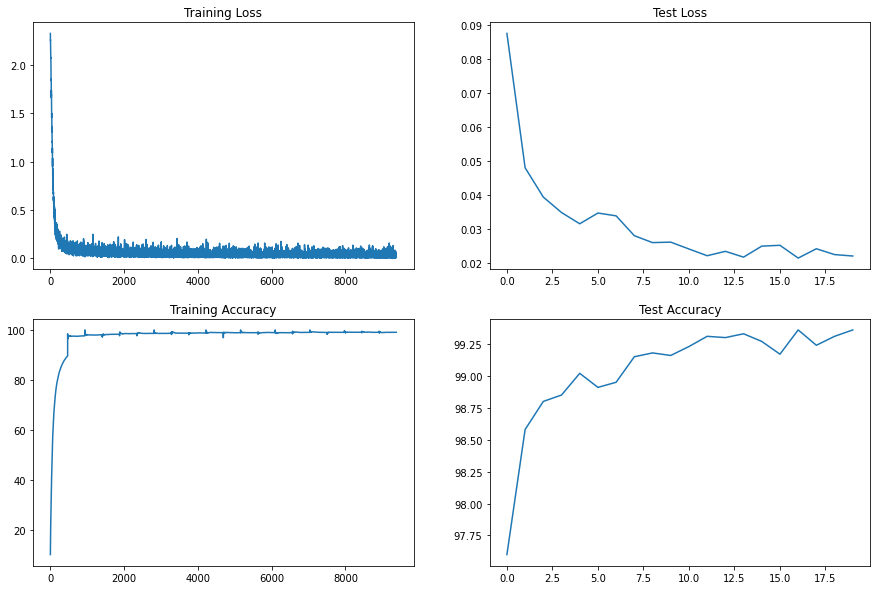

In [ ]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Results**
- Parameters: 9.5k (approx)
- Best train accuracy : 99.08
- Best test accracy: 99.36
**Analysis**:
- After adding image roation the model accuracy has reduced.
